![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Se evidencia que las observaciones estan desbalanceadas hacias comentarios negativos.

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentimientos por aerolínea'}, xlabel='airline'>

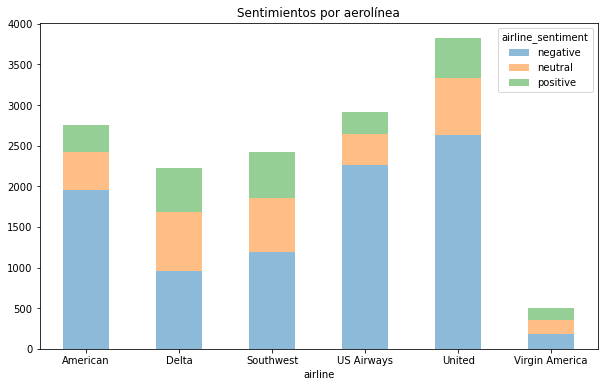

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentimientos por aerolínea")

In [8]:
#tweets.columns
#tweets.info()
tweets.isna().sum()

airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
#Exploracion set de entrenamiento, se cuenta con 9.808 documentos
print('Tamano XTrain:' , X_train.shape)
print('Tamano YTrain:' , y_train.shape)

display(X_train.head())
display(y_train.head())

Tamano XTrain: (9808,)
Tamano YTrain: (9808,)


tweet_id
569577005278064640                          @JetBlue of course I am!!✈️
569633482915209216    @AmericanAir complt incompetence on flt 295.La...
567829997668470785    @SouthwestAir Flight 4968 (N8325D) departs @MC...
569725021951791104    @USAirways does anyone from your airline know ...
567852278893416448                           @united I Want a Plane dad
Name: text, dtype: object

tweet_id
569577005278064640    0
569633482915209216   -1
567829997668470785   -1
569725021951791104   -1
567852278893416448    0
Name: airline_sentiment, dtype: int64

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
# Creación de matrices de documentos usando CountVectorizer a partir de X
vect1 = CountVectorizer(min_df = 0.01)
X1 = vect1.fit_transform(X_train)


In [19]:
# Definición de modelo Random Forest para un problema de clasificación
clf1 = RandomForestClassifier()

In [20]:
# Se calibra un modelo de Random Forest 
max_depths = [10, 30 , 50 , 100]
n_estimators = [10, 30, 50 ]
parameters = {'max_depth':max_depths , 'n_estimators': n_estimators}

clf1 = RandomForestClassifier(max_features='log2')
clf1_calib = GridSearchCV(clf1, parameters, n_jobs=-1)

In [21]:
#Calibración del modelo
clf1_calib.fit(X1,y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 100],
                         'n_estimators': [10, 30, 50]})

In [22]:
#Mejores parámetros obtenidos
clf1_calib.best_estimator_

RandomForestClassifier(max_depth=100, max_features='log2', n_estimators=50)

In [23]:
#Se realiza la transformación del CountVectorizer sobre X_Test
X1_test = vect1.transform(X_test)

In [24]:
#Se estima la predicción
predict1 = clf1_calib.predict(X1_test)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


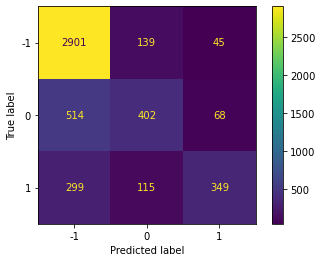

In [26]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predict1),display_labels = clf1_calib.classes_)
cm.plot()
plt.show()

In [27]:
# métrica para evaluar modelos de clasificación. 
# Es la fracción de predicciones que el modelo realiza correctamente.
accuracy_vect = accuracy_score(y_test, predict1)
print(accuracy_vect)

0.7557947019867549


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [28]:
# Se entrena el count vectorizer para generar una matriz que cuenta el numero de palabras en cada documento.
# Se aplicó stop_words ya que no aportan información, y se escogeran palabras que aparezcan en por lo menos en
# el 1% de los documentos

vect_stop = CountVectorizer(stop_words='english' , min_df=0.01)
X_stop = vect_stop.fit_transform(X_train)

X_stop.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
#A continuación se muestra el vocabulario generado.

vect_stop.vocabulary_

{'jetblue': 64,
 'americanair': 9,
 'delay': 30,
 'southwestair': 103,
 'flight': 43,
 'http': 62,
 'usairways': 122,
 'does': 36,
 'airline': 6,
 'know': 67,
 'united': 121,
 'want': 127,
 'plane': 90,
 'cancelled': 20,
 'flightled': 45,
 'going': 51,
 'trying': 120,
 'make': 78,
 'late': 68,
 'did': 33,
 'email': 39,
 'tell': 107,
 'bags': 14,
 'boarding': 17,
 'thank': 108,
 'right': 95,
 'amp': 10,
 'won': 130,
 'think': 110,
 'just': 66,
 'lost': 75,
 'customer': 26,
 'service': 101,
 'waiting': 126,
 '30': 1,
 'min': 79,
 'hold': 57,
 'left': 69,
 'bag': 12,
 'online': 86,
 'response': 94,
 'booked': 19,
 'change': 22,
 'problems': 91,
 'ticket': 111,
 'doesn': 37,
 'care': 21,
 'getting': 50,
 'baggage': 13,
 'airlines': 7,
 'luggage': 77,
 'aa': 2,
 'book': 18,
 'home': 58,
 'sent': 100,
 'let': 70,
 'bad': 11,
 'weather': 129,
 'number': 85,
 've': 123,
 'reservation': 93,
 'day': 28,
 'fleet': 42,
 'fleek': 41,
 'way': 128,
 'flights': 46,
 'time': 112,
 'need': 83,
 'rude': 

In [30]:
# Se calibra un modelo de Random Forest (se calibra sobre pocos parámetros por limitaciones de tiempo)

max_depths = [10, 30 , 50 , 100]
n_estimators = [10, 30, 50]
parameters=parameters = {'max_depth':max_depths , 'n_estimators': n_estimators}

clf2 = RandomForestClassifier(max_features='log2')
clf2_calib = GridSearchCV(clf2, parameters, n_jobs=-1)

In [31]:
#Calibración del modelo
clf2_calib.fit(X_stop,y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 100],
                         'n_estimators': [10, 30, 50]})

In [32]:
#Mejores parámetros obtenidos
clf2_calib.best_estimator_

RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=50)

In [33]:
#Se realiza la transformación del CountVectorizer sobre X_Test
X_test_stop = vect_stop.transform(X_test)
X_test_stop.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
#Se estima la predicción
predict_stop = clf2_calib.predict(X_test_stop)

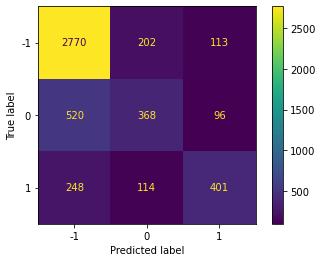

In [35]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predict_stop),display_labels = clf2_calib.classes_)
cm.plot()
plt.show()

In [36]:
# métrica para evaluar modelos de clasificación. 
# Es la fracción de predicciones que el modelo realiza correctamente.
accuracy_stop=accuracy_score(y_test, predict_stop)
print(accuracy_stop)

0.7324089403973509


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [37]:
# Celda 3
# Importación de librerias
import nltk
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jsmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
#Definicion de analizador que lematizara el texto como verbos

def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]


In [39]:
# Creación de matrices de documentos usando CountVectorizer, usando el analizador split_into_lemmas creado anteriormente
vect_lemas = CountVectorizer(analyzer=split_into_lemmas, min_df=0.01)

In [40]:
X_lem = vect_lemas.fit_transform(X_train)

In [41]:

vect_lemas.vocabulary_

{'@jetblue': 6,
 'of': 129,
 'i': 87,
 '@americanair': 5,
 'on': 131,
 'delay': 47,
 'from': 68,
 'a': 11,
 'that': 169,
 'last': 101,
 'no': 125,
 'and': 20,
 'not': 126,
 'what': 201,
 '@southwestair': 7,
 'flight': 62,
 'to': 182,
 '@usairways': 9,
 'do': 50,
 'your': 217,
 'airline': 16,
 'know': 100,
 'how': 85,
 'their': 172,
 '@united': 8,
 'want': 197,
 'plane': 143,
 'my': 120,
 'have': 77,
 'be': 29,
 'cancel': 39,
 'one': 132,
 'me.': 114,
 "what's": 202,
 'go': 72,
 'it': 95,
 "i'm": 89,
 'try': 188,
 'but': 34,
 'too': 185,
 'late': 102,
 'flight.': 63,
 'see': 150,
 'an': 19,
 'email': 54,
 'could': 43,
 'look': 108,
 'you': 213,
 'the': 171,
 'tell': 165,
 'me': 113,
 'where': 204,
 'bag': 27,
 'board': 32,
 'with': 208,
 'she': 153,
 'should': 154,
 'thank': 167,
 'or': 134,
 'u': 190,
 'now': 127,
 '&amp;': 0,
 "won't": 209,
 'think': 177,
 "that's": 170,
 'another': 21,
 'just': 98,
 'hang': 76,
 'up': 192,
 'by': 35,
 'customer': 45,
 'service': 152,
 'after': 13,
 '

In [42]:
max_depths = [10, 30 , 50 , 100]
n_estimators = [10, 30, 50]
parameters=parameters = {'max_depth':max_depths , 'n_estimators': n_estimators}

clf3 = RandomForestClassifier(max_features='log2')
clf3_calib = GridSearchCV(clf3, parameters, n_jobs=-1)

In [43]:
#Calibración del modelo
clf3_calib.fit(X_lem,y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 100],
                         'n_estimators': [10, 30, 50]})

In [44]:
X_test_lem = vect_lemas.transform(X_test)
X_test_lem.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
predict_lem = clf3_calib.predict(X_test_lem)

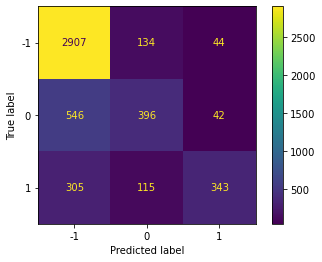

In [46]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predict_lem),display_labels = clf3_calib.classes_)
cm.plot()
plt.show()

In [47]:
accuracy_lem=accuracy_score(y_test, predict_lem)
print(accuracy_lem)

0.7545529801324503


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jsmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
#Debido a que el analyzer del CountVectorizer es una funcion, el parametro de stopwords no funcionaria. Por lo tanto es necesario incluir la eliminacion de stopwords en la funcion.

def split_into_lemmas_stop(text):
    from nltk.corpus import stopwords
    
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word , pos = 'v') for word in words if word not in stopwords.words('english')]

In [72]:

vect_stp_lem = CountVectorizer(analyzer=split_into_lemmas_stop, min_df=0.01)
X_stp_lem = vect_stp_lem.fit_transform(X_train)


In [73]:
vect_stp_lem.vocabulary_

{'@jetblue': 6,
 '@americanair': 5,
 'delay': 31,
 'last': 68,
 '@southwestair': 7,
 'flight': 42,
 '@usairways': 9,
 'airline': 12,
 'know': 67,
 '@united': 8,
 'want': 130,
 'plane': 95,
 'cancel': 23,
 'one': 90,
 'me.': 80,
 "what's": 133,
 'go': 50,
 "i'm": 62,
 'try': 123,
 'late': 69,
 'flight.': 43,
 'see': 101,
 'email': 34,
 'could': 27,
 'look': 75,
 'tell': 112,
 'bag': 17,
 'board': 19,
 'thank': 113,
 'u': 125,
 '&amp;': 0,
 'think': 116,
 "that's": 115,
 'another': 14,
 'hang': 54,
 'customer': 29,
 'service': 103,
 'wait': 129,
 'min': 81,
 'leave': 70,
 'book': 20,
 "can't": 22,
 'use': 128,
 'change': 24,
 'ticket': 117,
 'line': 73,
 'would': 136,
 'guy': 53,
 'get': 48,
 'baggage': 18,
 'unite': 126,
 'someone': 106,
 'luggage': 78,
 'make': 79,
 'put': 97,
 'send': 102,
 'let': 71,
 'weather': 132,
 'give': 49,
 'us': 127,
 'number': 89,
 'call': 21,
 'since': 104,
 'work': 134,
 "i've": 63,
 'day': 30,
 '3': 3,
 "fleet's": 41,
 'fleek.': 40,
 'way': 131,
 '-': 1,


In [74]:
max_depths = [10, 30 , 50 , 100]
n_estimators = [10, 30, 50]
parameters=parameters = {'max_depth':max_depths , 'n_estimators': n_estimators}

clf4 = RandomForestClassifier(max_features='log2')
clf4_calib = GridSearchCV(clf4, parameters, n_jobs=-1)

In [75]:
clf4_calib.fit(X_stp_lem , y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 100],
                         'n_estimators': [10, 30, 50]})

In [76]:
clf4_calib.best_estimator_

RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=50)

In [77]:
X_test_stp_lem = vect_stp_lem.transform(X_test)


In [78]:
predict_stp_lem = clf4_calib.predict(X_test_stp_lem)

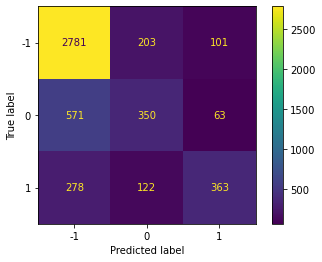

In [79]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predict_stp_lem),display_labels = clf4_calib.classes_)
cm.plot()
plt.show()

In [80]:
accuracy_stp_lemm = accuracy_score(y_test, predict_stp_lem)
print(accuracy_stp_lemm)

0.7230960264900662


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

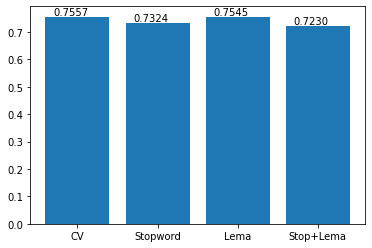

In [81]:
# Celda 5
modelos = ['CV' , 'Stopword', 'Lema', 'Stop+Lema']
valores = [accuracy_vect , accuracy_stop, accuracy_lem, accuracy_stp_lemm]
xpos = np.arange(len(valores))

plt.bar(modelos, valores)

for i, v in enumerate(valores):
    plt.text( x= xpos[i]-0.3, y=v, s = str(v)[0:6], verticalalignment='bottom')

De acuerdo a los resultados obtenidos el modelo con el mejor Accuracy general es el de vectorizacion simple (1-gramas), seguido por el de lematizacion de verbos.

Sin embargo vale la pena mirar el comportamiento por clases:
- El modelo que tiene mejor desempeño para predecir clase negativa es el de vectorizacion simple o el de lematizacion.
- El modelo que tiene mejor desempeño para predecir clase neutra es el de vectorizacion simple o el de lematización.
- El modelo que tiene mejor desempeño para predecir clase positiva es el de stopwords

In [82]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict1))
print(classification_report(y_test, predict_stop))
print(classification_report(y_test, predict_lem))
print(classification_report(y_test, predict_stp_lem))

              precision    recall  f1-score   support

          -1       0.78      0.94      0.85      3085
           0       0.61      0.41      0.49       984
           1       0.76      0.46      0.57       763

    accuracy                           0.76      4832
   macro avg       0.72      0.60      0.64      4832
weighted avg       0.74      0.76      0.73      4832

              precision    recall  f1-score   support

          -1       0.78      0.90      0.84      3085
           0       0.54      0.37      0.44       984
           1       0.66      0.53      0.58       763

    accuracy                           0.73      4832
   macro avg       0.66      0.60      0.62      4832
weighted avg       0.71      0.73      0.72      4832

              precision    recall  f1-score   support

          -1       0.77      0.94      0.85      3085
           0       0.61      0.40      0.49       984
           1       0.80      0.45      0.58       763

    accuracy        